In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tfa-nightly
!pip install tensorflow-addons
!pip install import-ipynb

In [3]:
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.models import *
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
import tensorflow as tf
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
import os
import numpy as np
np.warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow_addons as tfa
import pandas as pd
from google_drive_downloader import GoogleDriveDownloader as gdd
import matplotlib.pyplot as plt

from skimage.filters import sobel
from skimage import color
from sklearn.model_selection import train_test_split
from PIL import Image
from IPython.utils import io
import warnings
warnings.filterwarnings('ignore') # we ignore a RuntimeWarning produced from dividing by zero
import scipy.io as sio
import scipy.ndimage as ndimage
import lmdb, cv2, re, sys
#resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
#tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
#tf.tpu.experimental.initialize_tpu_system(resolver)
#print("All devices: ", tf.config.list_logical_devices('TPU'))
#strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [4]:
import tensorflow as tf
import os
import glob
import PIL
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from sklearn.model_selection import train_test_split

In [5]:
train_path = '/content/drive/MyDrive/MRI_ACDCA/training'
regions = {'epi': 2.0 , 'endo': 3.0 , 'rv' : 1.0 }
#test_size = 0.2
#target_size = (384,384)
crop_size = (128,128)

In [6]:
def center_crop(img, crop_size = (128,128)):
  w_in, h_in = img.shape
  w_out, h_out = crop_size
  img_clone = np.zeros((w_out, h_out))
  sub_w = int((w_in - w_out)/2)
  sub_h = int((h_in - h_out)/2)
  img_clone = img[sub_w:sub_w+w_out, sub_h:sub_h+h_out]
  return img_clone

In [7]:
train_file = '/content/drive/MyDrive/MRI_ACDCA/training/patient004'
i = 0 #thay doi cai nay nua
lis_img = glob.glob(train_file+'/*')
list_image = [aa for aa in lis_img if aa.find('frame') != -1 and aa.find('gt') == -1]

In [8]:
lis_img

['/content/drive/MyDrive/MRI_ACDCA/training/patient004/patient004_frame15.nii.gz',
 '/content/drive/MyDrive/MRI_ACDCA/training/patient004/patient004_frame01_gt.nii.gz',
 '/content/drive/MyDrive/MRI_ACDCA/training/patient004/Info.cfg',
 '/content/drive/MyDrive/MRI_ACDCA/training/patient004/patient004_frame15_gt.nii.gz',
 '/content/drive/MyDrive/MRI_ACDCA/training/patient004/patient004_frame01.nii.gz',
 '/content/drive/MyDrive/MRI_ACDCA/training/patient004/patient004_4d.nii.gz']

In [9]:
list_image

['/content/drive/MyDrive/MRI_ACDCA/training/patient004/patient004_frame15.nii.gz',
 '/content/drive/MyDrive/MRI_ACDCA/training/patient004/patient004_frame01.nii.gz']

In [10]:
#z=1 #thay doi cai nay de lay anh 
im = list_image[0]
num = im.find('nii')
im_gt = im[:num-1] + '_gt.' +im[num:]
image = nib.load(im)
label = nib.load(im_gt)
image = image.get_data().astype(np.uint8)
label = label.get_data()
sub_image = image[...,3]
sub_label = label[...,1]
sub_label = np.where(sub_label >= regions['endo'], 1.0, 0.0).astype(np.float32)

In [11]:
np.unique(image)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [12]:
crop_image = center_crop(image[...,3], crop_size = (128,128))
crop_label = center_crop(sub_label, crop_size = (128,128))

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8480140b90>,
 <matplotlib.image.AxesImage at 0x7f847fe20890>)

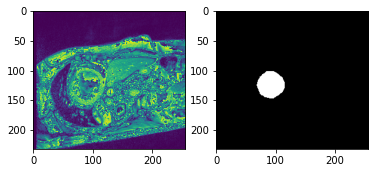

In [13]:
plt.figure(1)

plt.subplot(121),plt.imshow(sub_image) #cmap='gray'
plt.subplot(122),plt.imshow(sub_label,cmap='gray')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f847fe1df50>,
 <matplotlib.image.AxesImage at 0x7f847e8d7890>)

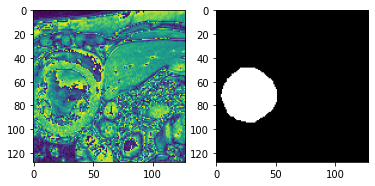

In [14]:
plt.figure(1)

plt.subplot(121),plt.imshow(crop_image) #cmap='gray'
plt.subplot(122),plt.imshow(crop_label,cmap='gray')

In [15]:
x=crop_label 
#x o day gia su la prediction nhe 
w_in, h_in = sub_image.shape
w_out, h_out = (128,128)
out = np.zeros((w_in, h_in))
sub_w = int((w_in - w_out)/2)
sub_h = int((h_in - h_out)/2)
out[sub_w:sub_w+w_out, sub_h:sub_h+h_out]= x

In [16]:
X = []
Y = []

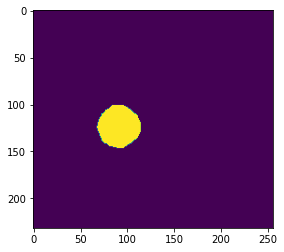

In [17]:
plt.imshow(out) #cmap='gray'

In [18]:
def get_data(list_file,is_crop = None ,target_size=(128,128), region = regions['endo']):
  
  x_train_list = []
  y_train_list = []
  

  for f in list_file:
    list_fimg = glob.glob(f+'/*')
    list_image = [aa for aa in list_fimg if aa.find('frame') != -1 and aa.find('gt') == -1]

    for im in list_image:
      num = im.find('nii')
      im_gt = im[:num-1] + '_gt.' +im[num:]
      image = nib.load(im)
      label = nib.load(im_gt)
      image = image.get_data().astype(np.uint8)
      #print(image.shape)
      label = label.get_data()

      for z in range(image.shape[-1]):
        sub_image = image[...,3]
        sub_label = label[...,1]
        sub_label = np.where(sub_label >= region, 1.0, 0.0).astype(np.float32)
        

        if is_crop:
          sub_label = center_crop(sub_label, crop_size=target_size) #target_size
          sub_image = center_crop(image[...,3], crop_size = target_size)

        else:
          sub_image  = PIL.Image.fromarray(sub_image)
          sub_label  = PIL.Image.fromarray(sub_label)
          sub_image = np.array(sub_image.resize(size=(target_size[0],target_size[1]),resample = PIL.Image.LANCZOS))
          sub_label = np.array(sub_label.resize(size=(target_size[0],target_size[1]),resample = PIL.Image.LANCZOS))

        y_train_list.append(sub_label)
        x_train_list.append(sub_image)
        
  x_ = np.asarray(x_train_list)
  y_ = np.asarray(y_train_list)
  print(x_.shape)
  return x_, np.expand_dims(y_, axis = -1)

In [19]:
def get_list_file(path=train_path,rate = 0.3,seed = 42):
  list_file = glob.glob(path+'/*')
  
  total_file = len(list_file)
  test_length = int(total_file*rate)
  train_length = total_file - test_length
  valid_length = int(test_length * 0.5)
  test_length = test_length - valid_length
  np.random.seed(42)
  idx = np.random.permutation(np.arange(total_file))
  train_file = np.asarray(list_file)[idx[:total_file-1]].tolist()
  #test_file = np.asarray(list_file)[idx[train_length:train_length+test_length]].tolist()
  #valid_file = np.asarray(list_file)[idx[train_length+test_length:]].tolist()
  return train_file #,test_file,valid_file

In [20]:
train_file = get_list_file(path=train_path) #,test_file,valid_file

In [21]:
train_file = glob.glob('/content/drive/MyDrive/MRI_ACDCA/training/*')
#test_file = glob.glob('/content/testing/*')

In [22]:
def save_data(target_size=(128,128),type_file = 'train', list_file = train_file):
  %cd '/content/drive/MyDrive/brain_mri_segmentation/dataset/cardiac_mri_acdc/'
  for is_crop in [True, False]:
    for j in ['endo','epi']:
      images , labels = get_data(list_file,is_crop = is_crop ,target_size=target_size, region = regions[j])
      
      #images_3D = np.concatenate([images,images,images],axis=-1)
      
      post1 = '_crop_' +str(target_size[1])+'.npy' if is_crop == True else '_' +str(target_size[1])+ '.npy'
      #post2 = '_crop_3D_'+str(target_size[1])+ '.npy' if is_crop == True else '_3D_' +str(target_size[1])+ '.npy'
      file_name = j + post1
      #file_name2 = j +post2
      np.save(type_file+'_image_'+file_name,images)
      np.save(type_file+'_label_'+file_name,labels)
      #np.save(type_file+'_image_'+file_name2,images_3D)


    



In [23]:
#save_data(type_file='train',list_file=train_file)
#save_data(type_file='test',list_file=test_file)
#save_data(type_file='valid',list_file=valid_file)
save_data(target_size=(128,128),type_file='train',list_file=train_file)
#save_data(target_size=(128,128),type_file='test',list_file=test_file)
#save_data(target_size=(128,128),type_file='valid',list_file=valid_file)

/content/drive/.shortcut-targets-by-id/1w-TuKfFg1p_kmorgOYNhTF-HPfPcx4Ab/brain_mri_segmentation/dataset/cardiac_mri_acdc


ValueError: ignored

In [ ]:
ls

NameError: ignored

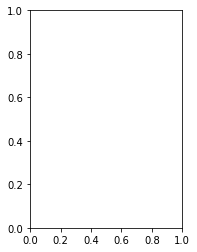

In [ ]:
for i in range(1,20,2):
  plt.figure(i)
  plt.subplot(121), plt.imshow(train_image_endo_128[i])
  plt.subplot(122), plt.imshow(np.squeeze(train_label_endo_128[i]),cmap='gray')
  plt.figure(i+1)

  plt.subplot(121), plt.imshow(train_image_endo_crop_128[i])
  plt.subplot(122), plt.imshow(np.squeeze(train_label_endo_crop_128[i]),cmap='gray')
  